#PUC Minas - Ciência da Computação
Disciplina: Inteligência Artificial

Integrantes do grupo:
Gustavo Garcia,
Igor Paschoalino,
Rafael Clark



Trabalho: TP2

# Importação de bibliotecas principais
- Nesta seção, importamos todas as bibliotecas necessárias para carregar, processar e avaliar o modelo de IA.


In [ ]:
import os
import time
import numpy as np
import torch
import kagglehub
import matplotlib.pyplot as plt
import tarfile
import torchvision

from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from sklearn.model_selection import train_test_split
from torch import optim
from torch import optim
from sklearn import metrics

# Configuração de Argumentos Pré-definidos
- Esta seção define os hiperparâmetros e configurações essenciais para o treinamento do modelo de IA.
- Inclui parâmetros como número de épocas, taxa de aprendizado, penalidade L2, momento, número de workers e tamanho do mini-batch.
- Além disso, verifica a disponibilidade de uma GPU para definir o dispositivo a ser utilizado (CPU ou CUDA).
- O valor de 'lr' em 'args' é atualizado para testes

In [ ]:
# Setting predefined arguments.
args = {
    'epoch_num': 5,      # Number of epochs.
    'lr': 1e-4,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 4,     # Number of workers on data loader.
    'batch_size': 32,    # Mini-batch size.
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cpu


# Download do Dataset com KaggleHub
 - Nesta seção, utilizamos o KaggleHub para baixar o dataset "200 Bird Species with 11788 Images".

 - O caminho dos arquivos baixados é salvo na variável `path`, e `data_dir` armazena o caminho base do dataset.


In [ ]:
# Baixar o dataset usando kagglehub
path = kagglehub.dataset_download("veeralakrishna/200-bird-species-with-11788-images")
print("Caminho para os arquivos do dataset:", path)

# Atualizar o caminho base do dataset para a variável `data_dir`
data_dir = path

Caminho para os arquivos do dataset: /root/.cache/kagglehub/datasets/veeralakrishna/200-bird-species-with-11788-images/versions/1


# Explorando o Diretório do Dataset
- Nesta seção, utilizamos `os.walk` para explorar a estrutura do diretório base do dataset.
- Exibimos os diretórios encontrados (subpastas) e limitamos a exibição a apenas os primeiros 5 arquivos.


In [ ]:
for root, dirs, files in os.walk(data_dir):
    print(f"Root: {root}")
    print(f"Dirs: {dirs}")
    print(f"Files: {files[:5]}")  # Limitar a exibição dos arquivos
    break

Root: /root/.cache/kagglehub/datasets/veeralakrishna/200-bird-species-with-11788-images/versions/1
Dirs: ['CUB_200_2011']
Files: ['segmentations.tgz', 'CUB_200_2011.tgz', 'attributes.txt']


# Extração do Arquivo Compactado
- Esta seção lida com a extração do arquivo `.tgz` baixado, caso ele ainda não tenha sido extraído.
- Após a extração, o caminho base do dataset (`data_dir`) é atualizado para apontar para a pasta de imagens extraídas.
- Finalmente, verificamos a estrutura do diretório para confirmar a organização dos dados.


In [ ]:
# Caminho do arquivo compactado
tgz_file = os.path.join(data_dir, "CUB_200_2011.tgz")

# Caminho de extração
extracted_path = os.path.join(data_dir, "CUB_200_2011")

# Extrair o arquivo se ainda não estiver extraído
if not os.path.exists(extracted_path):
    print(f"Extraindo {tgz_file}...")
    with tarfile.open(tgz_file, "r:gz") as tar:
        tar.extractall(path=data_dir)
    print("Extração concluída.")

# Atualizar data_dir para apontar para as imagens extraídas
data_dir = os.path.join(extracted_path, "images")

# Verificar a estrutura do diretório
for root, dirs, files in os.walk(data_dir):
    print(f"Root: {root}")
    print(f"Dirs: {dirs[:5]}")
    print(f"Files: {files[:5]}")
    break

Root: /root/.cache/kagglehub/datasets/veeralakrishna/200-bird-species-with-11788-images/versions/1/CUB_200_2011/images
Dirs: ['024.Red_faced_Cormorant', '020.Yellow_breasted_Chat', '091.Mockingbird', '194.Cactus_Wren', '151.Black_capped_Vireo']
Files: []


# Configuração de Transformações e Carregamento do Dataset
- Nesta seção, configuramos transformações para o pré-processamento do dataset, que incluem redimensionamento, conversão para tensores e normalização.
- Em seguida, utilizamos `datasets.ImageFolder` para carregar o dataset e verificamos informações básicas como o número de classes e exemplos de classes disponíveis.


In [ ]:
# Transformações para o dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar para 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizar para ImageNet
])

# Carregar o dataset com ImageFolder
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Verificar o número de classes e algumas amostras
print(f"Número de classes: {len(full_dataset.classes)}")
print(f"Classes: {full_dataset.classes[:5]}")  # Listar as primeiras 5 classes

args['n_classes'] = len(full_dataset.classes)

Número de classes: 200
Classes: ['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet']


# Divisão do Dataset em Treinamento e Validação
- Esta seção divide o dataset completo em dois subconjuntos: treinamento (80% dos dados) e validação (20% dos dados).
- Também configuramos DataLoaders para carregar os dados em mini-lotes de maneira eficiente durante o treinamento e validação.


In [ ]:
# Dividir dataset em treino e validação
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=False)

# Verificar classes
print("Classes:", full_dataset.classes)

Classes: ['001.Black_footed_Albatross', '002.Laysan_Albatross', '003.Sooty_Albatross', '004.Groove_billed_Ani', '005.Crested_Auklet', '006.Least_Auklet', '007.Parakeet_Auklet', '008.Rhinoceros_Auklet', '009.Brewer_Blackbird', '010.Red_winged_Blackbird', '011.Rusty_Blackbird', '012.Yellow_headed_Blackbird', '013.Bobolink', '014.Indigo_Bunting', '015.Lazuli_Bunting', '016.Painted_Bunting', '017.Cardinal', '018.Spotted_Catbird', '019.Gray_Catbird', '020.Yellow_breasted_Chat', '021.Eastern_Towhee', '022.Chuck_will_Widow', '023.Brandt_Cormorant', '024.Red_faced_Cormorant', '025.Pelagic_Cormorant', '026.Bronzed_Cowbird', '027.Shiny_Cowbird', '028.Brown_Creeper', '029.American_Crow', '030.Fish_Crow', '031.Black_billed_Cuckoo', '032.Mangrove_Cuckoo', '033.Yellow_billed_Cuckoo', '034.Gray_crowned_Rosy_Finch', '035.Purple_Finch', '036.Northern_Flicker', '037.Acadian_Flycatcher', '038.Great_Crested_Flycatcher', '039.Least_Flycatcher', '040.Olive_sided_Flycatcher', '041.Scissor_tailed_Flycatcher',

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Configuração do Modelo Pré-Treinado (ResNet)
- Nesta seção, carregamos um modelo ResNet-18 pré-treinado para transfer learning, modificamos a camada final para corresponder ao número de classes no dataset e movemos o modelo para o dispositivo configurado (CPU ou GPU).


In [ ]:
# Carregar o modelo ResNet pré-treinado
net = models.resnet18(pretrained=True, progress=False).to(args['device'])
net.fc = nn.Linear(in_features=512, out_features=200, bias=True).to(args['device'])
# model = models.resnet50(pretrained=True)

# # Congelar as camadas da ResNet
# for param in model.parameters():
#     param.requires_grad = False

# # Modificar a última camada para o número de classes
# model.fc = nn.Linear(model.fc.in_features, args['n_classes'])
# model = model.to(args['device'])

# Exibir modelo
print(net)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Configuração da Função de Perda e do Otimizador
- Nesta etapa, definimos a função de perda (*criterion*) para calcular os erros durante o treinamento e configuramos o otimizador (*optimizer*) para ajustar os pesos do modelo com base nesses erros.


In [ ]:
# Definir função de perda e otimizador
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       betas=(args['momentum'], 0.999),
                       weight_decay=args['weight_decay'])

criterion = nn.CrossEntropyLoss().to(args['device'])

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.fc.parameters(), args['lr'])

# Função de Treinamento
- Nesta função, realizamos o treinamento do modelo para uma época. Inclui o cálculo da perda, atualização dos gradientes, e registro das métricas.


In [ ]:
# Listas para armazenar os valores de perda e acurácia durante o treinamento
train_losses = []
val_losses = []
val_accuracies = []

def train(train_loader, net, criterion, optimizer, epoch):
    tic = time.time()

    net.train()
    train_loss = []

    for i, batch_data in enumerate(train_loader):
        inps, labs = batch_data
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        optimizer.zero_grad()
        outs = net(inps)
        loss = criterion(outs, labs)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.data.item())

    toc = time.time()
    train_loss = np.asarray(train_loss)

    # Armazenar a média da perda de treinamento
    train_losses.append(train_loss.mean())

    print('--------------------------------------------------------------------')
    print('[epoch %d], [train loss %.4f +/- %.4f], [training time %.2f]' % (
        epoch, train_loss.mean(), train_loss.std(), (toc - tic)))
    print('--------------------------------------------------------------------')

def test(test_loader, net, criterion, epoch):
    tic = time.time()

    net.eval()
    test_loss = []
    prd_list = []
    lab_list = []

    for i, batch_data in enumerate(test_loader):
        inps, labs = batch_data
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        outs = net(inps)
        loss = criterion(outs, labs)
        prds = outs.data.max(dim=1)[1].cpu().numpy()

        test_loss.append(loss.data.item())
        prd_list.extend(prds)
        lab_list.extend(labs.detach().cpu().numpy())

    toc = time.time()

    acc = metrics.accuracy_score(np.array(lab_list), np.array(prd_list))
    test_loss = np.asarray(test_loss)

    # Armazenar a perda de validação e a acurácia
    val_losses.append(test_loss.mean())
    val_accuracies.append(acc)

    print('--------------------------------------------------------------------')
    print('[epoch %d], [test loss %.4f +/- %.4f], [acc %.4f], [testing time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), acc, (toc - tic)))
    print('--------------------------------------------------------------------')


#Execução do loop principal de treinamento e validação do modelo.
- Nesta etapa, o modelo é treinado usando os dados de treino em cada época e avaliado com os dados de validação, permitindo monitorar o desempenho e a evolução do aprendizado.

In [ ]:
for epoch in range(1, args['epoch_num'] + 1):
    train(train_loader, net, criterion, optimizer, epoch)

    test(val_loader, net, criterion, epoch)

--------------------------------------------------------------------
[epoch 1], [train loss 3.9099 +/- 0.7765], [training time 2838.82]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 1], [test loss 2.6844 +/- 0.1874], [acc 0.4779], [testing time 231.22]
--------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


--------------------------------------------------------------------
[epoch 2], [train loss 1.9790 +/- 0.3021], [training time 2794.81]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 2], [test loss 1.7683 +/- 0.1903], [acc 0.6209], [testing time 228.37]
--------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


--------------------------------------------------------------------
[epoch 3], [train loss 1.0023 +/- 0.1608], [training time 2652.15]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 3], [test loss 1.4202 +/- 0.2236], [acc 0.6709], [testing time 226.74]
--------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


--------------------------------------------------------------------
[epoch 4], [train loss 0.4551 +/- 0.0967], [training time 2787.80]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 4], [test loss 1.2400 +/- 0.2191], [acc 0.6976], [testing time 236.39]
--------------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


--------------------------------------------------------------------
[epoch 5], [train loss 0.1782 +/- 0.0432], [training time 4486.31]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 5], [test loss 1.1986 +/- 0.2403], [acc 0.7125], [testing time 231.05]
--------------------------------------------------------------------


#Gráficos

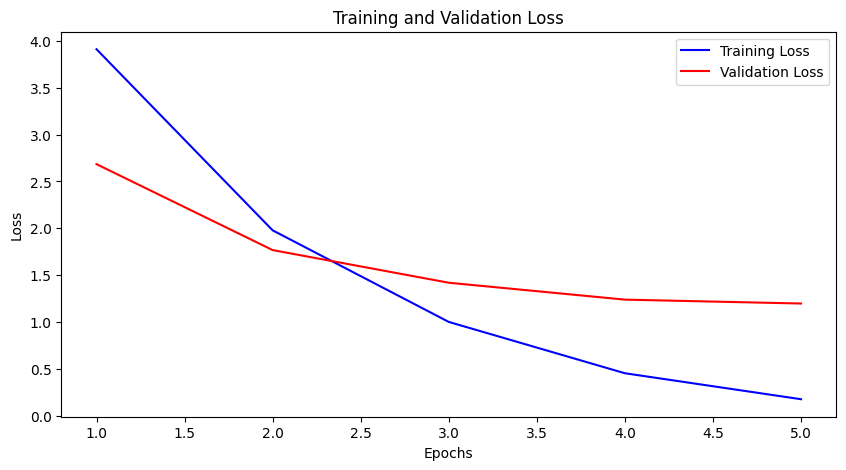

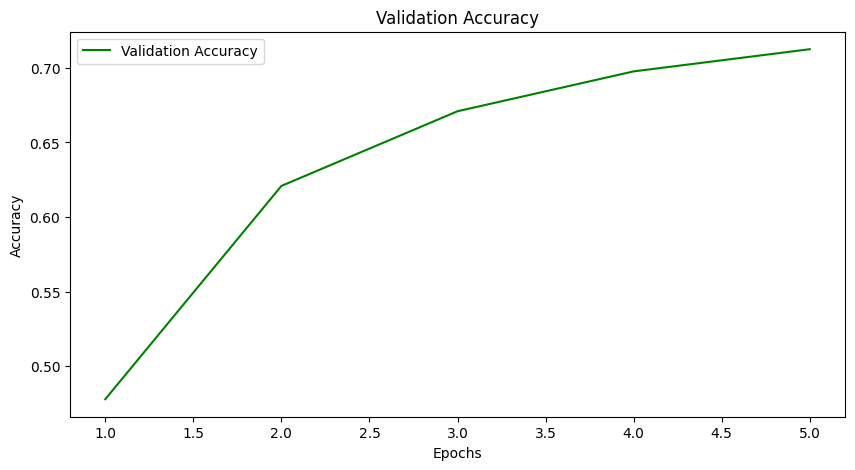

In [ ]:
# Plotar a perda de treinamento e validação
plt.figure(figsize=(10, 5))
plt.plot(range(1, args['epoch_num'] + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, args['epoch_num'] + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotar a acurácia de validação
plt.figure(figsize=(10, 5))
plt.plot(range(1, args['epoch_num'] + 1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()


#Resultados
##COM LR = 1e-3 :

[epoch 1], [train loss 1.8912 +/- 0.2520], [training time 2567.12]


[epoch 1], [test loss 2.6330 +/- 0.3762], [acc 0.3507], [testing time 223.69]


[epoch 2], [train loss 1.5136 +/- 0.2548], [training time 2583.47]


[epoch 2], [test loss 2.2927 +/- 0.3946], [acc 0.4020], [testing time 226.71]


[epoch 3], [train loss 1.2271 +/- 0.2369], [training time 3199.46]


[epoch 3], [test loss 2.0195 +/- 0.3286], [acc 0.4813], [testing time 209.73]


[epoch 4], [train loss 0.9916 +/- 0.2375], [training time 4742.80]


[epoch 4], [test loss 2.2644 +/- 0.3958], [acc 0.4258], [testing time 434.61]
## COM LR = 1e-4 :
[epoch 1], [train loss 3.9099 +/- 0.7765], [training time 2838.82]

[epoch 1], [test loss 2.6844 +/- 0.1874], [acc 0.4779], [testing time 231.22]

[epoch 2], [train loss 1.9790 +/- 0.3021], [training time 2794.81]

[epoch 2], [test loss 1.7683 +/- 0.1903], [acc 0.6209], [testing time 228.37]

[epoch 3], [train loss 1.0023 +/- 0.1608], [training time 2652.15]

[epoch 3], [test loss 1.4202 +/- 0.2236], [acc 0.6709], [testing time 226.74]

[epoch 4], [train loss 0.4551 +/- 0.0967], [training time 2787.80]

[epoch 4], [test loss 1.2400 +/- 0.2191], [acc 0.6976], [testing time 236.39]

[epoch 5], [train loss 0.1782 +/- 0.0432], [training time 4486.31]

[epoch 5], [test loss 1.1986 +/- 0.2403], [acc 0.7125], [testing time 231.05]

## COM LR = 1e-5 :

[epoch 1], [train loss 5.2811 +/- 0.1808], [training time 2590.27]

[epoch 1], [test loss 4.9964 +/- 0.1062], [acc 0.0348], [testing time 218.69]

[epoch 2], [train loss 4.6925 +/- 0.1555], [training time 2527.63]

[epoch 2], [test loss 4.4996 +/- 0.1158], [acc 0.1510], [testing time 225.65]

[epoch 3], [train loss 4.1890 +/- 0.1433], [training time 2512.80]

[epoch 3], [test loss 4.0690 +/- 0.1347], [acc 0.2523], [testing time 220.96]

[epoch 4], [train loss 3.7763 +/- 0.1454], [training time 2918.52]

[epoch 4], [test loss 3.7480 +/- 0.1424], [acc 0.3355], [testing time 215.07]

[epoch 5], [train loss 3.4341 +/- 0.1451], [training time 5116.97]

[epoch 5], [test loss 3.4468 +/- 0.1558], [acc 0.3944], [testing time 322.03]
